In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import os
import tempfile

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
temp_dir = "E:/TempAnaconda"  # Change to your available drive
os.makedirs(temp_dir, exist_ok=True)
os.environ['TMPDIR'] = temp_dir
os.environ['TEMP'] = temp_dir
os.environ['TMP'] = temp_dir

np.save
tempfile.tempdir = temp_dir

In [17]:
spgp_2023 = pd.read_csv('new_features_output.csv')

E:/TempAnaconda\ipykernel_27672\3456033944.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  spgp_2023 = pd.read_csv('new_features_output.csv')


In [80]:
ver_tel = spgp_2023[spgp_2023['Driver'] == 'GAS']
ver_tel = ver_tel.sort_values(by=['SessionTime']).copy()
ver_tel = ver_tel.reset_index(drop=True)

In [4]:
spgp_2022 = pd.read_csv('spgp2022_output.csv')

E:/TempAnaconda\ipykernel_27672\1768239134.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  spgp_2022 = pd.read_csv('spgp2022_output.csv')


In [5]:
feature_cols = ['RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'X', 'Y', 'Z', 'delta_time',
                'delta_speed', 'delta_throttle', 'delta_brake', 'delta_rpm', 'delta_gear',
       'acceleration', 'brake_mean_3', 'throttle_std_3', 'rpm_std_3', 'delta_x', 'delta_y', 'track_movement']

target_col = ['SCin30']

In [6]:
def prepare_multi_driver_data(df, feature_cols):
    """
    Prepare data for all drivers, handling missing values AND proper time sorting
    """
    print(f"Original data shape: {df.shape}")
    print(f"Drivers in dataset: {df['Driver'].unique()}")
    
    # CRITICAL: Sort data properly for each driver
    print("\nSorting data by driver and time...")
    df_sorted = df.copy()
    
    # Sort by Driver first, then by SessionTime (or Time) to ensure chronological order within each driver
    if 'SessionTime' in df.columns:
        df_sorted = df_sorted.sort_values(['Driver', 'SessionTime']).reset_index(drop=True)
        print("Sorted by Driver and SessionTime")
    elif 'Time' in df.columns:
        df_sorted = df_sorted.sort_values(['Driver', 'Time']).reset_index(drop=True)
        print("Sorted by Driver and Time")
    else:
        print("WARNING: No clear time column found. Using Distance as proxy.")
        df_sorted = df_sorted.sort_values(['Driver', 'Distance']).reset_index(drop=True)
    
    # Verify sorting worked
    print("\nVerifying sort order for each driver...")
    for driver in df_sorted['Driver'].unique()[:3]:  # Check first 3 drivers
        driver_data = df_sorted[df_sorted['Driver'] == driver]
        if 'SessionTime' in df.columns:
            time_col = 'SessionTime'
        elif 'Time' in df.columns:
            time_col = 'Time'
        else:
            time_col = 'Distance'
            
        is_sorted = driver_data[time_col].is_monotonic_increasing
        print(f"  {driver}: Time order correct = {is_sorted}")
        if not is_sorted:
            print(f"    WARNING: {driver} data is not properly time-ordered!")
    
    print(f"Driver counts: {df_sorted['Driver'].value_counts()}")
    
    # Rest of your cleaning code...
    df_clean = df_sorted.copy()
    
    print(f"Final cleaned data shape: {df_clean.shape}")
    print(f"Safety car distribution: {df_clean['SCin30'].value_counts()}")
    
    return df_clean

In [7]:
# Prepare your datasets
print("PREPARING 2022 DATA (TRAINING):")
df_2022_clean = prepare_multi_driver_data(spgp_2022, feature_cols)

#print("\nPREPARING 2023 DATA (TESTING):")
#df_2023_clean = prepare_multi_driver_data(spgp_2023, feature_cols)

PREPARING 2022 DATA (TRAINING):
Original data shape: (798048, 37)
Drivers in dataset: ['ALB' 'ALO' 'BOT' 'GAS' 'HAM' 'LAT' 'LEC' 'MAG' 'MSC' 'NOR' 'OCO' 'PER'
 'RIC' 'RUS' 'SAI' 'STR' 'TSU' 'VER' 'VET' 'ZHO']

Sorting data by driver and time...
Sorted by Driver and SessionTime

Verifying sort order for each driver...
  ALB: Time order correct = True
  ALO: Time order correct = True
  BOT: Time order correct = True
Driver counts: LAT    45129
ALB    45120
TSU    45088
MSC    45073
ZHO    45067
GAS    45047
VET    45043
STR    45019
BOT    45013
OCO    44985
PER    44949
VER    44917
ALO    44914
LEC    44902
SAI    44876
HAM    44855
RUS    44845
NOR    31852
MAG      677
RIC      677
Name: Driver, dtype: int64
Final cleaned data shape: (798048, 37)
Safety car distribution: 0.0    789720
1.0      8328
Name: SCin30, dtype: int64


In [8]:
def create_end_focused_sequences(df, feature_cols, target_col, sequence_length, prediction_horizon=30):
    """Use sequence to predict what happens AFTER the sequence"""
    X, y = [], []
    for i in range(len(df) - sequence_length - prediction_horizon + 1):
        # Features: current sequence
        seq_x = df.iloc[i:i+sequence_length][feature_cols].values
        
        # Target: what happens in the NEXT prediction_horizon timesteps
        future_window = df.iloc[i+sequence_length:i+sequence_length+prediction_horizon][target_col]
        seq_y = int(future_window.any())
        
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [81]:
# Test on 2023 (fewer safety car events) 
X_test_seq, y_test_seq = create_end_focused_sequences(
    ver_tel, feature_cols, 'SCin30',
    sequence_length=50, prediction_horizon=10
)

In [9]:
def create_sequences_all_drivers(df, feature_cols, target_col, sequence_length, prediction_horizon=30):
    """
    Create sequences for all drivers, ensuring sequences don't cross driver boundaries
    """
    all_X, all_y = [], []
    driver_info = []
    sequence_info = []  # Track sequence metadata
    
    print(f"Creating sequences with length={sequence_length}, prediction_horizon={prediction_horizon}")
    
    for driver in sorted(df['Driver'].unique()):
        print(f"\nProcessing {driver}...")
        
        # Get driver data and reset index
        driver_data = df[df['Driver'] == driver].copy().reset_index(drop=True)
        
        # Check if driver has enough data
        min_required = sequence_length + prediction_horizon
        if len(driver_data) < min_required:
            print(f"  Insufficient data for {driver}: {len(driver_data)} < {min_required}")
            continue
        
        # Create sequences for this driver
        driver_X, driver_y = create_end_focused_sequences(
            driver_data, feature_cols, target_col, sequence_length, prediction_horizon
        )
        
        if len(driver_X) > 0:
            all_X.append(driver_X)
            all_y.append(driver_y)
            
            # Track metadata
            driver_info.extend([driver] * len(driver_X))
            for i in range(len(driver_X)):
                sequence_info.append({
                    'driver': driver,
                    'sequence_idx': i,
                    'original_start_idx': i,
                    'driver_data_length': len(driver_data)
                })
            
            safety_car_count = np.sum(driver_y)
            print(f"  Created {len(driver_X)} sequences")
            print(f"  Safety car sequences: {safety_car_count} ({safety_car_count/len(driver_X)*100:.1f}%)")
    
    if all_X:
        X_combined = np.concatenate(all_X, axis=0)
        y_combined = np.concatenate(all_y, axis=0)
        
        print(f"\n{'='*50}")
        print("COMBINED DATASET SUMMARY:")
        print(f"{'='*50}")
        print(f"Total sequences: {len(X_combined):,}")
        print(f"Sequence shape: {X_combined.shape}")
        print(f"Total drivers: {len(set(driver_info))}")
        print(f"Drivers: {sorted(set(driver_info))}")
        print(f"Safety car sequences: {np.sum(y_combined):,} ({np.sum(y_combined)/len(y_combined)*100:.2f}%)")
        
        return X_combined, y_combined, driver_info, sequence_info
    else:
        raise ValueError("No sequences could be created for any driver")

In [10]:
# Create multi-driver datasets
print("="*60)
print("CREATING TRAINING SEQUENCES (2022 - ALL DRIVERS)")
print("="*60)

X_train_all, y_train_all, train_drivers, train_seq_info = create_sequences_all_drivers(
    df_2022_clean, feature_cols, 'SCin30', sequence_length=50, prediction_horizon=10
)

CREATING TRAINING SEQUENCES (2022 - ALL DRIVERS)
Creating sequences with length=50, prediction_horizon=10

Processing ALB...
  Created 45061 sequences
  Safety car sequences: 467 (1.0%)

Processing ALO...
  Created 44855 sequences
  Safety car sequences: 469 (1.0%)

Processing BOT...
  Created 44954 sequences
  Safety car sequences: 467 (1.0%)

Processing GAS...
  Created 44988 sequences
  Safety car sequences: 469 (1.0%)

Processing HAM...
  Created 44796 sequences
  Safety car sequences: 467 (1.0%)

Processing LAT...
  Created 45070 sequences
  Safety car sequences: 467 (1.0%)

Processing LEC...
  Created 44843 sequences
  Safety car sequences: 467 (1.0%)

Processing MAG...
  Created 618 sequences
  Safety car sequences: 236 (38.2%)

Processing MSC...
  Created 45014 sequences
  Safety car sequences: 469 (1.0%)

Processing NOR...
  Created 31793 sequences
  Safety car sequences: 236 (0.7%)

Processing OCO...
  Created 44926 sequences
  Safety car sequences: 469 (1.0%)

Processing PER

In [ ]:
#print("\n" + "="*60)
#print("CREATING TEST SEQUENCES (2023 - ALL DRIVERS)")
#print("="*60)

#X_test_all, y_test_all, test_drivers, test_seq_info = create_sequences_all_drivers(
#    df_2023_clean, feature_cols, 'SCin30', sequence_length=100, prediction_horizon=30
#)

In [82]:
#X_train_all = X_train_all.astype(np.float32)
#y_train_all = y_train_all.astype(np.float32)
X_test_all = X_test_seq.astype(np.float32)
y_test_all = y_test_seq.astype(np.float32)

In [ ]:
print(type(X_train_all))

In [83]:
#X_train_all = np.nan_to_num(X_train_all, nan=0.0, posinf=1e6, neginf=-1e6)
X_test_all = np.nan_to_num(X_test_all, nan=0.0, posinf=1e6, neginf=-1e6)

In [ ]:
#X_train_all = np.load('X_train_all.npy')
#y_train_all = np.load('y_train_all.npy')

In [13]:
from sklearn.preprocessing import StandardScaler

# Flatten X to 2D (combine sequences and time steps)
num_sequences, seq_len, num_features = X_train_all.shape
X_train_flat = X_train_all.reshape(-1, num_features)  # shape: (42692 * 30, 24)

# Fit and transform
scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_flat)

# Reshape back to (42692, 30, 24)
X_train_scaled = X_train_scaled_flat.reshape(num_sequences, seq_len, num_features)

In [84]:
num_sequences_test, seq_len_test, num_features_test = X_test_all.shape
X_test_flat = X_test_all.reshape(-1, num_features_test)  # shape: (42692 * 30, 24)

# Fit and transform
X_test_scaled_flat = scaler.fit_transform(X_test_flat)

# Reshape back to (42692, 30, 24)
X_test_scaled = X_test_scaled_flat.reshape(num_sequences_test, seq_len_test, num_features_test)

In [ ]:
#np.save('y_train_all.npy', y_train_all)

In [14]:
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        #self.sigmoid = nn.Sigmoid()  # For binary classification ##NEED TO REMOVE

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # take last time step
        out = self.fc(out)
        return out

In [15]:
# Create data loaders
train_dataset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train_all, dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Calculate class weights
pos_count = np.sum(y_train_all)
neg_count = len(y_train_all) - pos_count
pos_weight = torch.tensor([neg_count / pos_count])

print(f"\nTRAINING DATA STATISTICS:")
print(f"Total training sequences: {len(y_train_all):,}")
print(f"Negative samples: {neg_count:,}")
print(f"Positive samples: {pos_count:,}")
print(f"Class imbalance ratio: {neg_count/pos_count:.1f}:1")
print(f"Positive class weight: {pos_weight.item():.1f}")

# GPU Setup - ADD THIS SECTION
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Move pos_weight to GPU BEFORE creating criterion
pos_weight = pos_weight.to(device)

# Model setup
model = GRUClassifier(input_dim=len(feature_cols), hidden_dim=64, num_layers=2, output_dim=1)
model = model.to(device)  # Move model to GPU

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Now pos_weight is on GPU
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"\nMODEL ARCHITECTURE:")
print(f"Input dimension: {len(feature_cols)}")
print(f"Hidden dimension: 64")
print(f"Number of layers: 2")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


TRAINING DATA STATISTICS:
Total training sequences: 796,868
Negative samples: 788,207.0
Positive samples: 8,661.0
Class imbalance ratio: 91.0:1
Positive class weight: 91.0

Using device: cuda

MODEL ARCHITECTURE:
Input dimension: 21
Hidden dimension: 64
Number of layers: 2
Total parameters: 41,729


In [ ]:
#pos_weight = pos_weight.to(device)
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [16]:
# Move model and criterion to GPU
model = model.to(device)
criterion = criterion.to(device)

# Training
print(f"\n{'='*60}")
print("STARTING TRAINING")
print(f"{'='*60}")
num_epochs = 50
best_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for X_batch, y_batch in train_loader:
        # Move data to GPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    
    print(f"Epoch {epoch+1:2d}/{num_epochs}: Loss = {avg_loss:.4f}")
    
    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'best_multi_driver_model.pth')
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'feature_cols': feature_cols,
            'pos_weight': pos_weight.item(),
            'train_drivers': list(set(train_drivers)),
            #'test_drivers': list(set(test_drivers))
        }, f'multi_driver_checkpoint_epoch_{epoch+1}.pth')
print(f"\nTraining completed! Best loss: {best_loss:.4f}")


STARTING TRAINING
Epoch  1/50: Loss = 0.4831
Epoch  2/50: Loss = 0.1885
Epoch  3/50: Loss = 0.1041
Epoch  4/50: Loss = 0.0626
Epoch  5/50: Loss = 0.0434
Epoch  6/50: Loss = 0.0366
Epoch  7/50: Loss = 0.0246
Epoch  8/50: Loss = 0.0229
Epoch  9/50: Loss = 0.0218
Epoch 10/50: Loss = 0.0158
Epoch 11/50: Loss = 0.0163
Epoch 12/50: Loss = 0.0136
Epoch 13/50: Loss = 0.0127
Epoch 14/50: Loss = 0.0113
Epoch 15/50: Loss = 0.0142
Epoch 16/50: Loss = 0.0106
Epoch 17/50: Loss = 0.0106
Epoch 18/50: Loss = 0.0101
Epoch 19/50: Loss = 0.0125
Epoch 20/50: Loss = 0.0098
Epoch 21/50: Loss = 0.0106
Epoch 22/50: Loss = 0.0089
Epoch 23/50: Loss = 0.0093
Epoch 24/50: Loss = 0.0088
Epoch 25/50: Loss = 0.0101
Epoch 26/50: Loss = 0.0063
Epoch 27/50: Loss = 0.0099
Epoch 28/50: Loss = 0.0069
Epoch 29/50: Loss = 0.0083
Epoch 30/50: Loss = 0.0096
Epoch 31/50: Loss = 0.0070
Epoch 32/50: Loss = 0.0082
Epoch 33/50: Loss = 0.0099
Epoch 34/50: Loss = 0.0072
Epoch 35/50: Loss = 0.0066
Epoch 36/50: Loss = 0.0087
Epoch 37/

In [ ]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_multi_driver_model.pth'))

# Get predictions
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_test_scaled, dtype=torch.float32))
    probs = torch.sigmoid(logits).squeeze().numpy()

# Find best threshold
from sklearn.metrics import precision_recall_curve, f1_score

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test_all, probs)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print(f"\nBest threshold: {best_threshold:.3f}")
print(f"Best F1 score: {f1_scores[best_threshold_idx]:.3f}")

# Overall performance
pred_binary = (probs > best_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(f"\n{'='*60}")
print("OVERALL PERFORMANCE (ALL DRIVERS)")
print(f"{'='*60}")
print(classification_report(y_test_all, pred_binary, target_names=['No Safety Car', 'Safety Car']))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test_all, pred_binary)
print(f"                 Predicted")
print(f"                 No SC  Safety Car")
print(f"Actual No SC     {cm[0,0]:5d}  {cm[0,1]:9d}")
print(f"Actual Safety Car {cm[1,0]:4d}  {cm[1,1]:9d}")

In [ ]:
def analyze_performance_by_driver(y_true, y_pred, probs, driver_list, threshold):
    """
    Analyze model performance for each driver
    """
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    print(f"\n{'='*80}")
    print("PERFORMANCE BY DRIVER")
    print(f"{'='*80}")
    print(f"{'Driver':<12} {'Sequences':<10} {'SC_Actual':<10} {'SC_Pred':<9} {'TP':<4} {'FP':<4} {'FN':<4} {'Precision':<9} {'Recall':<8} {'F1':<8}")
    print("-" * 80)
    
    results = []
    
    for driver in sorted(set(driver_list)):
        driver_mask = np.array(driver_list) == driver
        
        driver_y_true = y_true[driver_mask]
        driver_y_pred = y_pred[driver_mask]
        driver_probs = probs[driver_mask]
        
        if len(driver_y_true) == 0:
            continue
            
        tp = np.sum((driver_y_pred == 1) & (driver_y_true == 1))
        fp = np.sum((driver_y_pred == 1) & (driver_y_true == 0))
        fn = np.sum((driver_y_pred == 0) & (driver_y_true == 1))
        tn = np.sum((driver_y_pred == 0) & (driver_y_true == 0))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"{driver:<12} {len(driver_y_true):<10} {np.sum(driver_y_true):<10} {np.sum(driver_y_pred):<9} {tp:<4} {fp:<4} {fn:<4} {precision:<9.3f} {recall:<8.3f} {f1:<8.3f}")
        
        results.append({
            'driver': driver,
            'sequences': len(driver_y_true),
            'actual_sc': np.sum(driver_y_true),
            'predicted_sc': np.sum(driver_y_pred),
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
            'precision': precision, 'recall': recall, 'f1': f1,
            'mean_prob': np.mean(driver_probs),
            'max_prob': np.max(driver_probs)
        })
    
    return results

# Run driver analysis
driver_results = analyze_performance_by_driver(
    y_test_all, pred_binary, probs, test_drivers, best_threshold
)

# Summary statistics
print(f"\n{'='*60}")
print("SUMMARY STATISTICS")
print(f"{'='*60}")
results_df = pd.DataFrame(driver_results)
print(f"Average F1 score across drivers: {results_df['f1'].mean():.3f} ± {results_df['f1'].std():.3f}")
print(f"Average precision across drivers: {results_df['precision'].mean():.3f} ± {results_df['precision'].std():.3f}")
print(f"Average recall across drivers: {results_df['recall'].mean():.3f} ± {results_df['recall'].std():.3f}")
print(f"Drivers with F1 > 0.5: {len(results_df[results_df['f1'] > 0.5])}/{len(results_df)}")

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def load_best_model(feature_cols, device='cpu'):
    """Load the best_multi_driver_model.pth file"""
    
    # Create model with same architecture you used in training
    model = GRUClassifier(
        input_dim=len(feature_cols), 
        hidden_dim=64, 
        num_layers=2, 
        output_dim=1
    )
    
    # Load the state dict
    model.load_state_dict(torch.load('best_multi_driver_model.pth', map_location=device))
    model = model.to(device)
    model.eval()
    
    print(f"Loaded best model with {len(feature_cols)} input features")
    return model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_best_model(feature_cols, device=device)
best_threshold = 0.5  # Default, you'll need to tune this

Loaded best model with 21 input features


E:/TempAnaconda\ipykernel_27672\3661578982.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_multi_driver_model.pth', map_location=

E:/TempAnaconda\ipykernel_27672\3190406671.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_multi_driver_model.pth', map_location=

Testing GAS
Sequences shape: (43272, 50, 21)
Labels shape: (43272,)
Positive sequences: 158.0 (0.37%)

RESULTS:
Precision: 0.006
Recall: 0.019
F1-Score: 0.009
Accuracy: 0.985
TP: 3, FP: 491, FN: 155, TN: 42623
Safety Cars Caught: 3/158.0 (1.9%)


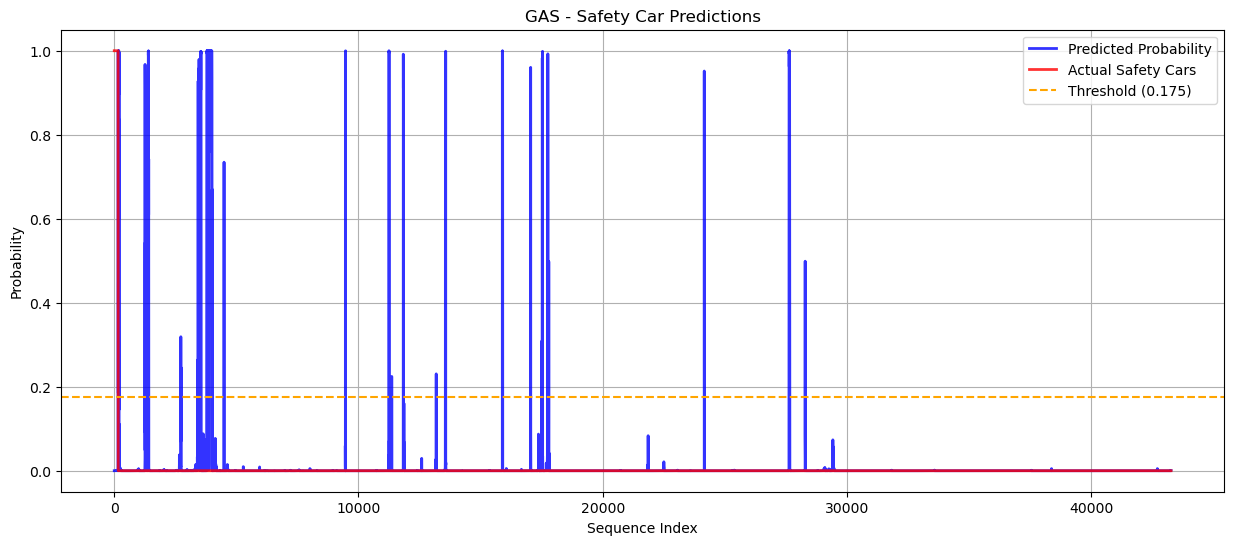

In [85]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def test_with_existing_sequences(model, X_sequences, y_sequences, driver_name, 
                                threshold=0.5, device='cpu'):
    """
    Test model with pre-created sequences
    """
    print(f"Testing {driver_name}")
    print(f"Sequences shape: {X_sequences.shape}")
    print(f"Labels shape: {y_sequences.shape}")
    print(f"Positive sequences: {np.sum(y_sequences)} ({np.sum(y_sequences)/len(y_sequences)*100:.2f}%)")
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_sequences, dtype=torch.float32).to(device)
        logits = model(X_tensor)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
    
    pred_binary = (probs > threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_sequences, pred_binary, zero_division=0)
    recall = recall_score(y_sequences, pred_binary, zero_division=0)
    f1 = f1_score(y_sequences, pred_binary, zero_division=0)
    accuracy = np.mean(y_sequences == pred_binary)
    
    cm = confusion_matrix(y_sequences, pred_binary)
    tn, fp, fn, tp = cm.ravel()
    
    # Print results
    print(f"\nRESULTS:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
    
    if np.sum(y_sequences) > 0:
        print(f"Safety Cars Caught: {tp}/{np.sum(y_sequences)} ({tp/np.sum(y_sequences)*100:.1f}%)")
    
    # Plot
    plt.figure(figsize=(15, 6))
    plt.plot(probs, alpha=0.8, label='Predicted Probability', color='blue', linewidth=2)
    plt.plot(y_sequences, alpha=0.8, label='Actual Safety Cars', color='red', linewidth=2)
    plt.axhline(y=threshold, color='orange', linestyle='--', label=f'Threshold ({threshold})')
    plt.title(f'{driver_name} - Safety Car Predictions')
    plt.xlabel('Sequence Index')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'driver': driver_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'probabilities': probs,
        'actual': y_sequences,
        'predicted': pred_binary
    }

# Load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GRUClassifier(input_dim=len(feature_cols), hidden_dim=64, num_layers=2, output_dim=1)
model.load_state_dict(torch.load('best_multi_driver_model.pth', map_location=device))
model = model.to(device)

# Test with your sequences
result = test_with_existing_sequences(
    model, 
    X_test_scaled,     # Your X array
    y_test_all,     # Your y array  
    'GAS',        # Driver name for display
    threshold=0.175,
    device=device
)

In [ ]:
import gc

# Clear CUDA cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

# Check available memory
if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

In [41]:
# Check when safety cars occur for Verstappen
safety_car_indices = np.where(y_test_all == 1)[0]
print(f"Safety car events at sequence indices: {safety_car_indices[:20]}...")  # First 20
print(f"Safety car events span: {safety_car_indices.min()} to {safety_car_indices.max()}")

# Check if model predictions align with actual events
high_prob_indices = np.where(result['probabilities'] > 0.1)[0]
print(f"High probability predictions at: {high_prob_indices[:20]}...")

Safety car events at sequence indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]...
Safety car events span: 0 to 157
High probability predictions at: [19 20 21 22 23 24 25 26 27 28 29 30 31 32 41 42 43 44 45 46]...


In [29]:
# Look for systematic offset
actual_period = np.arange(0, 108)  # Where safety cars actually were
predicted_periods = [
    np.arange(88, 100),      # Early predictions (some overlap)
    np.arange(1112, 1150),   # Later predictions 
    np.arange(2324, 2350)    # Much later predictions
]

print("Timing analysis:")
print(f"Actual safety car period: sequences {actual_period.min()}-{actual_period.max()}")
for i, pred_period in enumerate(predicted_periods):
    offset = pred_period.min() - actual_period.min()
    print(f"Prediction group {i+1}: sequences {pred_period.min()}-{pred_period.max()}, offset: +{offset}")

Timing analysis:
Actual safety car period: sequences 0-107
Prediction group 1: sequences 88-99, offset: +88
Prediction group 2: sequences 1112-1149, offset: +1112
Prediction group 3: sequences 2324-2349, offset: +2324
